## Dimensionality Reduction

**Sylvie Fortier**

__Part 1__

Load the MNIST dataset

In [1]:
# For consistency in graphs throughout the notebook
import numpy as np
import pandas as pd

# For consistency in figures throughout the notebook
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Make this notebook's output stable across runs
np.random.seed(123)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Select Performance Measures

A common way to evaluate a model is to look at the accuracy of the model. However, accuracy is generally not the preferred performance measure for classifiers, especially with skewed data in a dataset (i.e., when some classes are much more frequent than others).

A good way to evaluation model performance is to use cross-validation along with other performance measures such as Precision and Recall, F1 score, and computing the ROC AUC. 

As a rule of thumb, the Precision and Recall (F1 score) is prefered whenever the positive class "1" is rare or when the false positives are more important than the false negatives, and the ROC AUC is prefered otherwise.

Since our dataset is nicely balanced, we will look at all performance measures but will prefer the ROC AUC over accuracy and F1 score (precision and recall) to choose the best model.

# Data Inspection and Cleaning

In [2]:
# Read CSV data file in float16 to save memory
df = pd.read_csv('mnist_dataset.csv').astype(np.float16)
df.head(3)

Unnamed: 0  label  1x1  1x2  1x3  ...  28x24  28x25  28x26  28x27  28x28
0         0.0    2.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0
1         1.0    5.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0
2         2.0    8.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0

[3 rows x 786 columns]

In [3]:
# from google.colab import files
# uploaded = files.upload()

In [4]:
# Check for data types
df.dtypes

Unnamed: 0    float16
label         float16
1x1           float16
1x2           float16
1x3           float16
               ...   
28x24         float16
28x25         float16
28x26         float16
28x27         float16
28x28         float16
Length: 786, dtype: object

In [5]:
# Check for missing values
df.isnull().values.any()

False

In [6]:
# Check for duplicates
df.duplicated().any()

False

In [7]:
# Check number of observations and columns
df.shape

(70000, 786)

In [8]:
# Check columns names
df.columns

Index(['Unnamed: 0', 'label', '1x1', '1x2', '1x3', '1x4', '1x5', '1x6', '1x7',
       '1x8',
       ...
       '28x19', '28x20', '28x21', '28x22', '28x23', '28x24', '28x25', '28x26',
       '28x27', '28x28'],
      dtype='object', length=786)

In [9]:
# Rename first column
df.rename(columns = {'Unnamed: 0':'unnamed'}, inplace=True)
df.columns

Index(['unnamed', 'label', '1x1', '1x2', '1x3', '1x4', '1x5', '1x6', '1x7',
       '1x8',
       ...
       '28x19', '28x20', '28x21', '28x22', '28x23', '28x24', '28x25', '28x26',
       '28x27', '28x28'],
      dtype='object', length=786)

In [10]:
# Check index names
df.index

RangeIndex(start=0, stop=70000, step=1)

In [11]:
# Determine min and max values
df.describe().loc[['min','max']]

unnamed  label  1x1  1x2  1x3  ...  28x24  28x25  28x26  28x27  28x28
min      0.0    0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0
max      inf    9.0  0.0  0.0  0.0  ...   62.0    0.0    0.0    0.0    0.0

[2 rows x 786 columns]

In [12]:
# Create data DF
df_data = df.iloc[:,2:] # starting column 3 for a total of 784 features/ 70000 rows
print(df_data.shape)

# Create labels DF
df_labels = df['label'].astype(int)
print(df_labels.shape)

(70000, 784)
(70000,)


# Build Baseline Model

Baseline model is a plain vanilla model without hyperparameters tuning or excessive feature engineering. However, some feature engineering could be needed such as feature scaling when appropriate.

## Determine X and y

In [13]:
# Define X
X = df_data

# Define y 
y = df_labels 

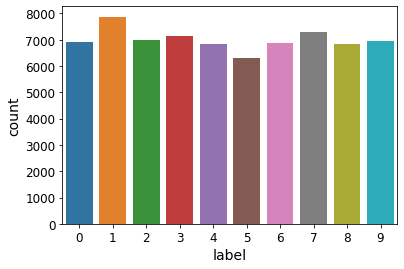

[6903, 7877, 6990, 7141, 6824, 6313, 6876, 7293, 6825, 6958]


In [14]:
#Check the frequency of each label
sns.countplot(y)
plt.show()

print(list(y.value_counts().sort_index()))

## Create train/test sets

In [15]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, shuffle=False, stratify=None, random_state=0)

print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (60000, 784)
X_test.shape: (10000, 784)
y_train.shape: (60000,)
y_test.shape: (10000,)


**Note:** <br>
It's important to have similar proportions of each category between the training and test sets. Therefore, we'll determine if the dataset was equally split.

In [16]:
# Define custom function
def check_dataset_balance(series):
    
    # find unique values
    unique = series.value_counts()
    display(unique)
    
    # plot a pie chart to see if data are balanced
    plt.pie(x=unique, explode=[0.05]*len(unique), autopct='%1.1f%%', colors=sns.color_palette('pastel'))
    plt.show()

1    6722
7    6245
3    6102
2    5983
0    5944
9    5937
6    5904
4    5899
8    5872
5    5392
Name: label, dtype: int64

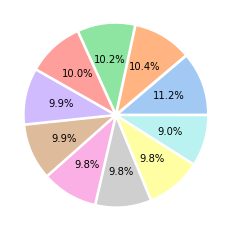

1    1155
7    1048
3    1039
9    1021
2    1007
6     972
0     959
8     953
4     925
5     921
Name: label, dtype: int64

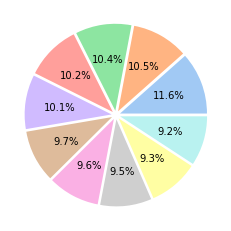

In [17]:
# Verify that the train and test sets are equally split

# Call the function with series=y_train
check_dataset_balance(y_train)

# Call the function with series=y_test
check_dataset_balance(y_test)

__Part 2__

Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set.

## Pipeline - Baseline

**Transformation pipeline: to clean up and prepare the data for ML.**

- Typical transformation pipeline for numerical features are [impute, scale, feature selection], and categorical features are [impute, encode, feature selection] <br>
- Since it's safer to apply an imputer because future data migh have missing values after the system goes live, we will add it to the pipeline even though there's currently no missing values in the dataset<br>
- Although some DR methods are affected by feature scaling, since all features are on the same scale (pixel brightness) a Scaler is not needed on this dataset. <br>
- Scaling the target is generally not required.

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from time import time
t0 = time()

# Full pipeline (transformer + estimator)
full_pipe_baseline = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('classifier', RandomForestClassifier(class_weight='balanced', random_state=1, n_jobs=-1,))
                ])

# Fit (and transform) the pipeline to training data to create a model as an object format
rfc_baseline = full_pipe_baseline.fit(X_train, y_train)

#--------------------------------------------------------------------
# Processing time
pipe_pre = time() - t0
print('Classifier Train Time : %d seconds' % pipe_pre)

Classifier Train Time : 42 seconds


## Performance Measures - Baseline

### (i) Cross-Validation

A good way to evaluate a model is to use cross-validation which takes a random sample of data points so that if you run it multiple times the performance metrics will be different each time. To get more accurate results, you need to run many iterations and then calculate the average.

**Compute predictions from test set**

In [19]:
from time import time
t0 = time()

# Define model
model = rfc_baseline

# Compute predictions (yhat) using test set (10000,)
yhat_test = model.predict(X_test)

# List of probabilities that the classifier assigned using test set (10000,)
yproba_test = model.predict_proba(X_test)

#---------------------------------------------------------------------------------------------
# Processing time
prediction_pre = time() - t0
print('Classifier Train Time : %d seconds' % prediction_pre)

Classifier Train Time : 1 seconds


**Print performance measures**

In [20]:
from sklearn.metrics import classification_report

target_names = ['label 0', 'label 1', 'label 2', 'label 3','label 4','label 5','label 6','label 7','label 8','label 9']

# Create the classification report
report_pre = classification_report(y_test, yhat_test, target_names=target_names, digits=3, output_dict=True)
f1_pre = report_pre['macro avg']['f1-score']

# Print the Classification Report
print('Classification Report\n >> Test Set <<\n' + classification_report(y_test, yhat_test, target_names=target_names, digits=3))

#--------------------------------------------------------------------------------------------------------------------------
# Print the accuracy score (%)
accuracy_pre = report_pre['accuracy']
print('Accuracy >>> {}'.format(round(accuracy_pre*100, 1)), '%\n') 


#-------------------------------------------------------------------------------
from sklearn.metrics import roc_auc_score

# ROC UAC for multiclass classification using macro average
macro_roc_auc_pre = roc_auc_score(y_test, yproba_test, multi_class="ovr", average="macro")

# ROC UAC for multiclass classification using weighted average
weighted_roc_auc_pre = roc_auc_score(y_test, yproba_test, multi_class="ovr", average="weighted")

# Print ROC AUC scores
print('One-vs-Rest ROC AUC scores: \n{:.4f} (macro), \n{:.4f} (weighted by prevalence)'.format(macro_roc_auc_pre, weighted_roc_auc_pre))


Classification Report
 >> Test Set <<
              precision    recall  f1-score   support

     label 0      0.981     0.986     0.984       959
     label 1      0.985     0.990     0.987      1155
     label 2      0.965     0.972     0.969      1007
     label 3      0.963     0.947     0.955      1039
     label 4      0.969     0.976     0.973       925
     label 5      0.970     0.971     0.970       921
     label 6      0.983     0.990     0.986       972
     label 7      0.967     0.974     0.971      1048
     label 8      0.960     0.959     0.960       953
     label 9      0.960     0.937     0.948      1021

    accuracy                          0.970     10000
   macro avg      0.970     0.970     0.970     10000
weighted avg      0.970     0.970     0.970     10000

Accuracy >>> 97.0 %

One-vs-Rest ROC AUC scores: 
0.9992 (macro), 
0.9992 (weighted by prevalence)


### (ii) Confusion Matrix

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

class_names = range(10)

# Compare error rate (absolute)
ConfusionMatrixDisplay.from_predictions(y_test, yhat_test, normalize=None, labels=class_names, cmap=plt.cm.Blues)
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.title('Confusion Matrix (absolute)')

# Compare error rate (normalized)
ConfusionMatrixDisplay.from_predictions(y_test, yhat_test, normalize='true', labels=class_names, values_format='.2f', cmap=plt.cm.Blues) 
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.title('Confusion Matrix (normalized)')
plt.show()


"\nclass_names = range(10)\n\n# Compare error rate (absolute)\nConfusionMatrixDisplay.from_predictions(y_test, yhat_test, normalize=None, labels=class_names, cmap=plt.cm.Blues)\nfig = plt.gcf()\nfig.set_size_inches(6,6)\nplt.title('Confusion Matrix (absolute)')\n\n# Compare error rate (normalized)\nConfusionMatrixDisplay.from_predictions(y_test, yhat_test, normalize='true', labels=class_names, values_format='.2f', cmap=plt.cm.Blues) \nfig = plt.gcf()\nfig.set_size_inches(6,6)\nplt.title('Confusion Matrix (normalized)')\nplt.show()\n"

__Note:__<br>
The baseline model already correctly classified between 95-99% of all labels pretty good ! 

### (iii) ROC AUC Graph

**Plot ROC curves for multiclass classification**

ROC curves are typically used in binary classification to study the output of a classifier. In order to extend ROC curve and ROC area to multi-label classification, it is necessary to binarize the output. 

Note: <br>
In new release scikit-learn 0.22, the roc_auc_score function can now also be used in multi-class classification. 
`roc_auc = roc_auc_score(y, model.predict_proba(X), multi_class="ovo")`

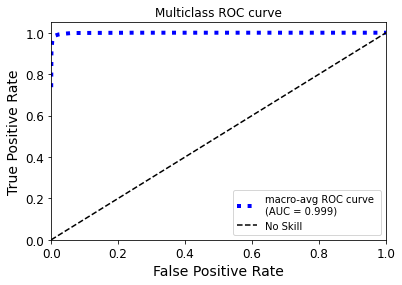

In [22]:
# Binarize the output
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc

y = label_binarize(y, classes=[0,1,2,3,4,5,6,7,8,9])
n_classes = y.shape[1]

#--------------------------------------------------------------
# Compute ROC curve and ROC area for each class

fpr = {}
tpr = {}
thresh = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, yproba_test[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

#---------------------------------------------------------------
# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Iterpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#----------------------------------------------------------------
# Plot all ROC curves
plt.figure()

plt.plot(
    fpr['macro'],
    tpr['macro'],
    label="macro-avg ROC curve \n(AUC = {0:0.3f})".format(roc_auc["macro"]),
    color='blue', linestyle=':', linewidth=4)

    
# Plot no skill in black
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='No Skill')    
    
# Settings    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Multiclass ROC curve')
plt.legend(loc='best')
plt.show()

## Feature Importance - Baseline Model

In [23]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(class_weight='balanced',
                             random_state=1, n_jobs=-1)

rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

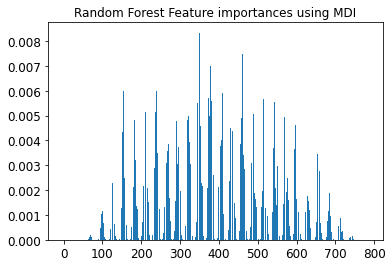

In [24]:
# Determine feature importance
importance = rfc.feature_importances_

# Plot feature importance score
plt.bar([x for x in range(len(importance))], importance)
plt.title("Random Forest Feature importances using MDI")
plt.show()

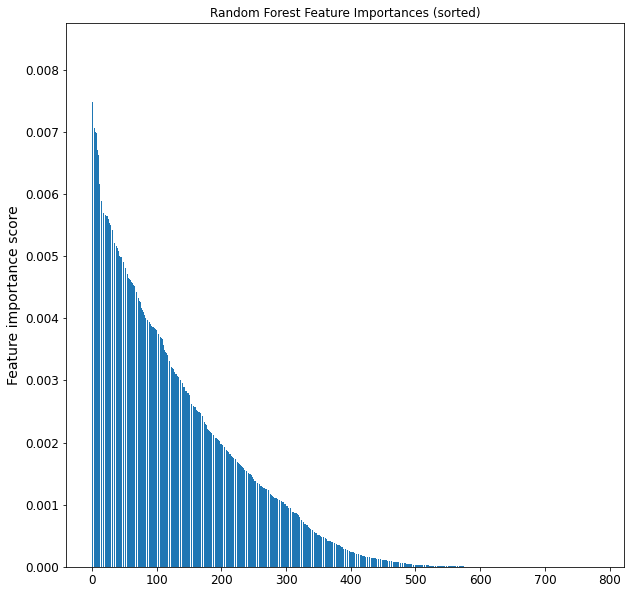

In [25]:
# Plot feature importance score (sorted)
importance = sorted(rfc.feature_importances_, reverse=True)

plt.rcParams["figure.figsize"] = (10,10)
plt.bar([x for x in range(len(importance))], importance)

# Settings
plt.title("Random Forest Feature Importances (sorted)")
plt.ylabel('Feature importance score')
plt.show()

**Determine the feature importance score for the top 10 features**

In [26]:
# Top 10 feature importance score
importance = sorted(rfc.feature_importances_, reverse=True)
importance_10 = importance[:10]

# Print feature importances in order
for i,v in enumerate(importance_10):
    print('Score: %.6f' % v)

Score: 0.008335
Score: 0.007484
Score: 0.007199
Score: 0.007080
Score: 0.007069
Score: 0.007059
Score: 0.006993
Score: 0.006990
Score: 0.006925
Score: 0.006703


**Determine the feature name for the top 20 features**

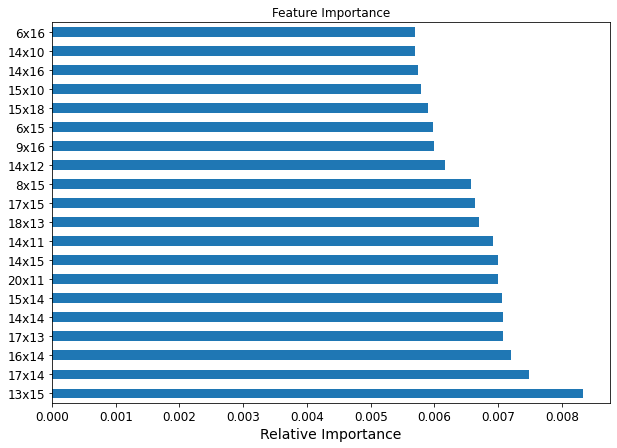

In [27]:
# plot the 20 most important features 
plt.figure(figsize=(10,7))
feature_importances = pd.Series(rfc.feature_importances_, index = X_train.columns)
feature_importances.nlargest(20).plot(kind='barh')

# Settings
plt.title('Feature Importance')
plt.xlabel('Relative Importance')
plt.show()

# Reduction Model - PCA

__Part 3__ <br>
(i) Next, use PCA to reduce the dataset’s dimensionality, with an explained variance ratio of 95%. <br>
(ii) Train a new Random Forest classifier on the reduced dataset and see how long it takes. <br>
(iii) Was training much faster? <br>
(iv) Next evaluate the classifier on the test set: how does it compare to the previous classifier?

## Fit the PCA transformer

Another way to find the number of reduced dimensions: 

In [28]:
from sklearn.decomposition import PCA

# Initialize PCA by passing n_components
pca = PCA(n_components=0.95) 

# Call fit_transform methods by passing scaled features (if required)
X_reduced_pca = pca.fit_transform(X_train) 

print(f"Shape of X_reduced_pca = {X_reduced_pca.shape}")

Shape of X_reduced_pca = (60000, 154)


## Number of dimensions

In [29]:
pca.n_components_ 

154

In [30]:
# Cumulative explained variance ratio
np.cumsum(pca.explained_variance_ratio_)

array([0.09756058, 0.16915899, 0.23063937, 0.28459061, 0.33342966,
       0.37654322, 0.40939696, 0.43821507, 0.4658842 , 0.48930503,
       0.51039625, 0.5308135 , 0.54783184, 0.56475495, 0.58053589,
       0.5953311 , 0.6085164 , 0.62130632, 0.63319435, 0.64473397,
       0.65542629, 0.66551417, 0.67510533, 0.68418523, 0.69300448,
       0.7013944 , 0.70951005, 0.71736108, 0.72474342, 0.73165273,
       0.73823211, 0.74469487, 0.75074202, 0.75658862, 0.76225257,
       0.76768158, 0.77272182, 0.77760017, 0.78237439, 0.78705328,
       0.79157893, 0.79603128, 0.80021561, 0.80416895, 0.80800286,
       0.81176204, 0.81538759, 0.81888284, 0.82226564, 0.82546307,
       0.82862913, 0.83172899, 0.83470077, 0.83756148, 0.84038381,
       0.84308238, 0.84575712, 0.84832161, 0.85085528, 0.85330572,
       0.8557033 , 0.85809309, 0.86037112, 0.86258477, 0.86471671,
       0.86677581, 0.86881303, 0.87076297, 0.87268447, 0.87456883,
       0.87643831, 0.87823894, 0.8800087 , 0.88173719, 0.88338

It shows that the first component captured only 9.7% of the variance and we need a large number of principal components to explain 95% of the variance in the training set.

In [31]:
# Cumulative variance
cumsum = np.sum(pca.explained_variance_ratio_)*100
print('Cumulative explained variation for {} principal components: {}'.format(pca.n_components_, round(cumsum,2)), '%')

Cumulative explained variation for 154 principal components: 95.04 %


In [32]:
delta = (1 - pca.explained_variance_ratio_.sum())*100

print('By projecting down to {}D, we lost about {} % of the variance'.format(pca.n_components_, round(delta,2)))

By projecting down to 154D, we lost about 4.96 % of the variance


In [33]:
plt.figure(figsize=(6, 4))

# Plot cumulative variance in relation to number dimensions
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2)
plt.axvline(x=pca.n_components_, linestyle='--', color='black', label='new dimensions')
plt.axhline(y=pca.n_components, linestyle='--', color='orange', label='95% variance')

# Settings
plt.grid()
plt.xlabel("Dimensions")
plt.ylabel("cumulative variance retained")
plt.legend(loc='best')
plt.show()

In [34]:
# Visualize individual variance in relation to number of dimensions
pca_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.bar(range(len(pca_variance)), pca_variance, alpha=0.5, align='center', label='individual variance')

# Settings
plt.xlabel('Principal components (dimensions)')
plt.ylabel('Variance')
plt.legend()
plt.show()

## Train Classifier - PCA

Re-train RF classifier using the X_reduced produced by PCA

## Pipeline - PCA

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from time import time
t0 = time()

# Full pipeline (transformers + estimator)
full_pipe_pca = Pipeline([
                ('reducer', PCA(n_components=0.95)),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('classifier', RandomForestClassifier(class_weight='balanced', random_state=1, n_jobs=-1,))
                ])

# Fit (and transform) the pipeline to training data to create a model as an object format
rfc_pca = full_pipe_pca.fit(X_train, y_train)

#--------------------------------------------------------------------
# Processing time
pipe_pca = time() - t0
print('Pipeline Time : %d seconds' % pipe_pca)

Pipeline Time : 101 seconds


## Performance Measures - PCA

### (i) Cross-Validation

**Compute predictions using test set**

In [36]:
from time import time
t0 = time()

# Define model
model = rfc_pca

# Compute predictions (yhat) using test set (10000,)
yhat_pca = model.predict(X_test)

# List of probabilities that the classifier assigned using test set (10000,)
yproba_pca = model.predict_proba(X_test)


# Processing time
prediction_pca = time() - t0
print('Classifier Train Time : %d seconds' % prediction_pca)

Classifier Train Time : 1 seconds


**Performance Measures**

In [37]:
from sklearn.metrics import classification_report

target_names = ['label 0', 'label 1', 'label 2', 'label 3','label 4','label 5','label 6','label 7','label 8','label 9']

# Create the classification report
report_pca = classification_report(y_test, yhat_pca, target_names=target_names, digits=3, output_dict=True)
f1_pca= report_pca['macro avg']['f1-score']

# Print the Classification Report
print('Classification Report\n >> Test Set <<\n' + classification_report(y_test, yhat_pca, target_names=target_names, digits=3))

#--------------------------------------------------------------------------------------------------------------------------
# Print the accuracy score (%)
accuracy_pca = report_pca['accuracy']
print('Accuracy >>> {}'.format(round(accuracy_pca*100, 1)), '%\n') 

#-------------------------------------------------------------------------------
from sklearn.metrics import roc_auc_score

# ROC UAC for multiclass classification using macro average
macro_roc_auc_pca = roc_auc_score(y_test, yproba_pca, multi_class="ovr", average="macro")

# Print ROC AUC scores
print('One-vs-Rest ROC AUC scores: \n{:.4f} (macro)'.format(macro_roc_auc_pca))

Classification Report
 >> Test Set <<
              precision    recall  f1-score   support

     label 0      0.979     0.974     0.976       959
     label 1      0.984     0.985     0.984      1155
     label 2      0.937     0.945     0.941      1007
     label 3      0.922     0.927     0.924      1039
     label 4      0.928     0.955     0.941       925
     label 5      0.932     0.941     0.937       921
     label 6      0.965     0.976     0.971       972
     label 7      0.952     0.955     0.954      1048
     label 8      0.932     0.917     0.924       953
     label 9      0.945     0.902     0.923      1021

    accuracy                          0.948     10000
   macro avg      0.948     0.948     0.948     10000
weighted avg      0.948     0.948     0.948     10000

Accuracy >>> 94.8 %

One-vs-Rest ROC AUC scores: 
0.9971 (macro)


### (ii) Confusion Matrix

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay

class_names = range(10)

# Compare error rate (absolute)
ConfusionMatrixDisplay.from_predictions(y_test, yhat_pca, normalize=None, labels=class_names, cmap=plt.cm.Blues)
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.title('Confusion Matrix (absolute)')

# Compare error rate (normalized)
ConfusionMatrixDisplay.from_predictions(y_test, yhat_pca, normalize='true', labels=class_names, values_format='.2f', cmap=plt.cm.Blues) 
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.title('Confusion Matrix (normalized)')
plt.show()

"\nclass_names = range(10)\n\n# Compare error rate (absolute)\nConfusionMatrixDisplay.from_predictions(y_test, yhat_pca, normalize=None, labels=class_names, cmap=plt.cm.Blues)\nfig = plt.gcf()\nfig.set_size_inches(6,6)\nplt.title('Confusion Matrix (absolute)')\n\n# Compare error rate (normalized)\nConfusionMatrixDisplay.from_predictions(y_test, yhat_pca, normalize='true', labels=class_names, values_format='.2f', cmap=plt.cm.Blues) \nfig = plt.gcf()\nfig.set_size_inches(6,6)\nplt.title('Confusion Matrix (normalized)')\nplt.show()\n"

__Note:__<br>
The model after PCA correctly classified between 90-98% of all labels 

### (iii) ROC AUC Graph

In [39]:
# Binarize the output
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc

y = label_binarize(y, classes=[0,1,2,3,4,5,6,7,8,9])
n_classes = y.shape[1]

#--------------------------------------------------------------
# Compute ROC curve and ROC area for each class

fpr = {}
tpr = {}
thresh = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, yproba_pca[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

#---------------------------------------------------------------
# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Iterpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#----------------------------------------------------------------
# Plot ROC curve
plt.figure()

plt.plot(
    fpr['macro'],
    tpr['macro'],
    label='macro-avg ROC curve \n(AUC = {0:0.3f})'.format(roc_auc['macro']),
    color='blue', linestyle=':', linewidth=4)

# Plot no skill in black
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='No Skill')    
    
# Settings    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC curve using PCA')
plt.legend(loc='best')
plt.show()

# Reduction Model - TSNE

__Part 4__ <br> Use t-SNE to reduce the MNIST dataset, show result graphically.

The main purpose of t-SNE is visualization of high-dimensional data. Hence, it works best when the data will be embedded on two or three dimensions. The goal of this algorithm is to find similar probability distribution in low-dimensional space

TSNE doesn't look at points given their position in the high dimension space it just looks at the distance between that point and its neighbors and try to respect these relations in the low dims space. In simple terms, t-SNE gives you a feel of how the data are arranged in high-dimensional space.

## Pipeline - TSNE

We'll try two ways to reduce the number of dimensions. First starting with the original dataset (784 features) and the second from the already reduced data from PCA (154 features) as recommended by sklearn.

Please note that since t-SNE is a computationally expensive operation for which I'm unable to use the entire X_train set, we will use only 20k observations because otherwise the kernel crashes.

(i) t-SNE using X_train (20000,784) without prior dimensionality reduction

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
import time
t0 = time.time()

""" This cell is inactive to avoid having to run it everytime the kernel is restarted. It takes about 13 min each time!"""

'''
pipe_tsne = Pipeline([
                ('reducer', TSNE(n_components=2, perplexity=40, n_iter=300)),
                ('imputer', SimpleImputer(strategy='most_frequent'))                
                ])

# Transform the data on the features only (no need on the labels)
X_reduced_tsne = pipe_tsne.fit_transform(X_train[0:20000])

print(f"Shape of X_reduced_tsne after TSNE pipeline = {X_reduced_tsne.shape}")

#---------------------------------------------------------------------------
# Processing time
delta_pipe_tsne = time.time() - t0
print('\nPipeline Time (TSNE): %d seconds' % delta_pipe_tsne)
'''

'\npipe_tsne = Pipeline([\n                (\'reducer\', TSNE(n_components=2, perplexity=40, n_iter=300)),\n                (\'imputer\', SimpleImputer(strategy=\'most_frequent\'))                \n                ])\n\n# Transform the data on the features only (no need on the labels)\nX_reduced_tsne = pipe_tsne.fit_transform(X_train[0:20000])\n\nprint(f"Shape of X_reduced_tsne after TSNE pipeline = {X_reduced_tsne.shape}")\n\n#---------------------------------------------------------------------------\n# Processing time\ndelta_pipe_tsne = time.time() - t0\nprint(\'\nPipeline Time (TSNE): %d seconds\' % delta_pipe_tsne)\n'

(ii) t-SNE using X_reduced_pca (20000,154) with prior PCA dimensionality reduction

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
import time
t0 = time.time()

""" Cannot include a classifer in a pipeline with TSNE because it doesn't have a transform() method"""

pipe_tsne = Pipeline([
                 ('imputer', SimpleImputer(strategy='most_frequent')),
                 ('reducer', TSNE(n_components=2, perplexity=40, n_iter=300))
                ])

# Fit and transform the training data on the features only (no need on the labels)
X_reduced_tsne_pca = pipe_tsne.fit_transform(X_reduced_pca[0:20000])

print(f"Shape of X_reduced_tsne_pca = {X_reduced_tsne_pca.shape}")

#---------------------------------------------------------------------------
# Processing time
pipe_tsne_pca = time.time() - t0
print('\nPipeline Time (PCA+TSNE) : %d seconds' % pipe_tsne_pca)


Shape of X_reduced_tsne_pca = (20000, 2)

Pipeline Time (PCA+TSNE) : 255 seconds


**Note:**<br>
TNSE is already very slow and it takes nearly 3 times longer to reduced the dataset to 2D when we start with 784 features as compared to when we start with 154 features. I guess it explains the note from sklearn :"It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples". However, we need to also account for the time for PCA to reduce it first to 154 features. Still, I think we save half the time compared to starting from scratch so good call sklearn!

## Visualization - TSNE

In [42]:
# Create a smaller DF so that results can be added
df_subset = df[0:20000]

""" Some lines are hashtaged because I don't run the previous cell regularly. The image of the 2 graphs was added to the droxbox for reference"""

# Add results from t-SNE to the DF
# df_subset['$z_1tsne$'] = X_reduced_tsne[:,0]
# df_subset['$z_2tsne$'] = X_reduced_tsne[:,1]
df_subset['$z_1pca&tsne$'] = X_reduced_tsne_pca[:,0]
df_subset['$z_2pca&tsne$'] = X_reduced_tsne_pca[:,1]

# Pre-settings
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 2, 1)

# Plot t-SNE (alone) results
# sns.scatterplot(
#     x='$z_1tsne$',
#     y='$z_2tsne$',
#     data=df_subset,
#     hue='label',
#     palette=sns.color_palette("hls", 10),
#     legend="full",
#     # alpha=0.3,
#     ax=ax1)
# plt.title('MNIST dataset with two components using t-SNE alone')


# Plot t-SNE (+PCA) results
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x='$z_1pca&tsne$',
    y='$z_2pca&tsne$',
    data=df_subset,
    hue='label',
    palette=sns.color_palette("hls", 10),
    legend="full",
    # alpha=0.3,
    ax=ax2)
plt.title('MNIST dataset with two components using PCA + t-SNE', fontsize=14)

plt.show()


>>> Please refer to attached image (dropbox) instead of running the code for the 2 graphs.

**Note:**<br>
The two graphs above look very similar, same clusters but a different orientation. It is nice to see how t-SNE can differentiate the clusters easily. Therefore, this method is a good choice if we need a visual 2D representation of the dataset but otherwise is very much too slow to reduce the dataset with this method just for processing. 

## Performance Measures - TSNE

### Train Classifier - TSNE

We first need to train the classifier with only two components. Since X_train has 784 features, we need to use X_reduced instead. 

Also, since t-SNE doesn't have the transform() method, it cannot be used to transform X_test to use it to make prediction. Therefore, the X_reduced must be used along with `cross_val_predict`

In [43]:

# Define X
X_reduced_tsne_pca
print('Shape of X_reduced_tsne_pca:', X_reduced_tsne_pca.shape)

# Define y
y_train[0:20000]
print('Shape of y_train w/o reduction: ', y_train[0:20000].shape)


Shape of X_reduced_tsne_pca: (20000, 2)
Shape of y_train w/o reduction:  (20000,)


In [44]:
from sklearn.ensemble import RandomForestClassifier

# Train the classifer using the fit() method with the training set to create the model (object)
rfc = RandomForestClassifier(class_weight='balanced',
                            random_state=1,
                            n_jobs=-1)

# Fit with training data to create a new model as an object
rfc_tsne = rfc.fit(X_reduced_tsne_pca, y_train[0:20000])


### (i) Cross-Validation

Since the new model (rfc_tsne) only take 2 features as an input, we cannot use `model.predict(X_test)` with 784 features. Moreover, we can't reduce X_test to 2 features like we did with X_train (using fit_transform() method) because we can't use fit_tranform() on X_test and the transform() only method doesn't exist with TSNE. So, we can't use X_test in this situation to make predictions. We will then use `cross_val_predict(model, X_train, y_train)` instead to make predictions.

In [45]:
from sklearn.model_selection import cross_val_predict
from time import time
t0 = time()

model = rfc_tsne

# Create predictions (y_hat) using the training set
yhat_tsne = cross_val_predict(model, X_reduced_tsne_pca, y_train[0:20000], cv=3, method='predict') 

# List of probabilities that the classifier assigned to each instance for each class (using training set)
yproba_tsne = cross_val_predict(model, X_reduced_tsne_pca, y_train[0:20000], cv=3, method='predict_proba') 


#------------------------------------------------------------------
# Processing time
prediction_tsne_pca = time() - t0
print('Predictions Time : %d seconds' % prediction_tsne_pca)


Predictions Time : 12 seconds


In [46]:
from sklearn.metrics import classification_report

target_names = ['label 0', 'label 1', 'label 2', 'label 3','label 4','label 5','label 6','label 7','label 8','label 9']

# Create the classification report
report_tsne = classification_report(y_train[0:20000], yhat_tsne, target_names=target_names, digits=3, output_dict=True)
f1_tsne= report_tsne['macro avg']['f1-score']

# Print the Classification Report
print('Classification Report\n >> Training Set <<\n' + classification_report(y_train[0:20000], yhat_tsne, target_names=target_names, digits=3))

#--------------------------------------------------------------------------------------------------------------------------
# Print the accuracy score (%)
accuracy_tsne = report_tsne['accuracy']
print('Accuracy >>> {}'.format(round(accuracy_tsne*100, 1)), '%\n') 

#------------------------------------------------------------------------------------------------------------------------------------------------
from sklearn.metrics import roc_auc_score

# ROC AUC for multiclass using macro average
macro_roc_auc_tsne = roc_auc_score(y_train[0:20000], yproba_tsne, multi_class="ovr", average="macro")

# Print ROC AUC scores
print("One-vs-Rest ROC AUC scores: \n{:.4f} (macro)".format(macro_roc_auc_tsne))


Classification Report
 >> Training Set <<
              precision    recall  f1-score   support

     label 0      0.971     0.986     0.979      1961
     label 1      0.950     0.985     0.967      2256
     label 2      0.960     0.948     0.954      1938
     label 3      0.918     0.905     0.911      2012
     label 4      0.723     0.695     0.709      1942
     label 5      0.904     0.920     0.912      1849
     label 6      0.972     0.980     0.976      2007
     label 7      0.930     0.917     0.924      2102
     label 8      0.906     0.863     0.884      1969
     label 9      0.671     0.702     0.686      1964

    accuracy                          0.892     20000
   macro avg      0.891     0.890     0.890     20000
weighted avg      0.892     0.892     0.892     20000

Accuracy >>> 89.2 %

One-vs-Rest ROC AUC scores: 
0.9817 (macro)


### (ii) Confusion Matrix

Again training set will be used along with `cross_val_predict` (yhat_pca) to create the confusion matrix instead of using X_test

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay

class_names = range(10)

# Compare error rate (absolute)
ConfusionMatrixDisplay.from_predictions(y_train[0:20000], yhat_pca, normalize=None, labels=class_names, cmap=plt.cm.Blues)
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.title('Confusion Matrix (absolute)')

# Compare error rate (normalized)
ConfusionMatrixDisplay.from_predictions(y_train[0:20000], yhat_pca, normalize='true', labels=class_names, values_format='.2f', cmap=plt.cm.Blues) 
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.title('Confusion Matrix (normalized)')
plt.show()


"\nclass_names = range(10)\n\n# Compare error rate (absolute)\nConfusionMatrixDisplay.from_predictions(y_train[0:20000], yhat_pca, normalize=None, labels=class_names, cmap=plt.cm.Blues)\nfig = plt.gcf()\nfig.set_size_inches(6,6)\nplt.title('Confusion Matrix (absolute)')\n\n# Compare error rate (normalized)\nConfusionMatrixDisplay.from_predictions(y_train[0:20000], yhat_pca, normalize='true', labels=class_names, values_format='.2f', cmap=plt.cm.Blues) \nfig = plt.gcf()\nfig.set_size_inches(6,6)\nplt.title('Confusion Matrix (normalized)')\nplt.show()\n"

### (iii) ROC AUC Graph

In [48]:
# Binarize the output
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc

y = label_binarize(y, classes=[0,1,2,3,4,5,6,7,8,9])
n_classes = y.shape[1]

#--------------------------------------------------------------
# Compute ROC curve and ROC area for each class

fpr = {}
tpr = {}
thresh = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_train[0:20000], yproba_tsne[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

#---------------------------------------------------------------
# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Iterpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#----------------------------------------------------------------
# Plot all ROC curves
plt.figure()

plt.plot(
    fpr['macro'],
    tpr['macro'],
    label="macro-avg ROC curve \n(AUC = {0:0.3f})".format(roc_auc["macro"]),
    color='blue', linestyle=':', linewidth=4)

    
# Plot no skill in black
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='No Skill')    
    
# Settings    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC curve using t-SNE')
plt.legend(loc='best')
plt.show()


# Reduction Model - Others
Let's create a list of different dimensionality reduction methods to determine visually if they seem to work or not for this dataset.

In [49]:
from sklearn.decomposition import TruncatedSVD as SVD
from sklearn.manifold import Isomap, SpectralEmbedding, LocallyLinearEmbedding, MDS, TSNE
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.random_projection import SparseRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

n_neighbors = 30
n = 50 # based on GridSearch performed (codes shown later in this notebook)

embeddings = {
    'Random projection embedding': SparseRandomProjection(n_components=n, random_state=42),
    'SVD embedding': SVD(n_components=n),
    'Isomap embedding': Isomap(n_neighbors=n_neighbors, n_components=n),
    'Spectral embedding': SpectralEmbedding(n_components=n, random_state=0, eigen_solver='arpack'),
    'NCA embedding': NeighborhoodComponentsAnalysis(n_components=n, init='auto', random_state=0),
    'LLE embedding': LocallyLinearEmbedding(n_components=n, n_neighbors=10, random_state=1),
    'MDS embedding': MDS(n_components=n, random_state=1),
    'LDA embedding': LinearDiscriminantAnalysis(n_components=9), # n=classes-1
    'TSNE embedding': TSNE(n_components=2, perplexity=40, n_iter=300)
}

In [50]:
""" Note: cannot use more than 10k observations because NCA is memory inefficient and uses too much RAM and Isomap, MDS and TSNE are really slow."""

# Pre-settings
fig = plt.figure(figsize=(20,20))
count = 1
projections, timing = {}, {}

for name, transformer in embeddings.items():
    if name.startswith('LDA'):
        data = X_train[0:10000].copy()
        data = np.array(data)
        data.flat[:: X_train[0:10000].shape[1] + 1] += 0.01  # Make X invertible
    else:
        data = X_train[0:10000]

    print(f'Computing {name}...')
    t0 = time()
    projections[name] = transformer.fit_transform(data, y_train[0:10000])
    timing[name] = time() - t0
    print(timing[name])
    print(projections[name].shape)

    plt.subplot(3,3,count)
   
    sns.scatterplot(
    x=projections[name][:, 0],
    y=projections[name][:, 1],
    data=df[0:10000],
    hue='label',
    palette=sns.color_palette('tab10'),
    legend="full",
    alpha=0.3)

    plt.title(f"{name} (time {timing[name]:.3f}s)", fontsize=10)
    count +=1
    

Computing Random projection embedding...
0.1684098243713379
(10000, 50)
Computing SVD embedding...
7.470993757247925
(10000, 50)
Computing Isomap embedding...
480.71303272247314
(10000, 50)
Computing Spectral embedding...
374.8206322193146
(10000, 50)
Computing NCA embedding...
9.391818761825562
(10000, 50)
Computing LLE embedding...
327.38403820991516
(10000, 50)
Computing MDS embedding...
4386.941934585571
(10000, 50)
Computing LDA embedding...
3.525620937347412
(10000, 9)
Computing TSNE embedding...
225.081116437912
(10000, 2)


**Note:**<br>
We can only plot 2D but it gives a good comparison of the first two dimensions among dimensionality reduction methods. Seven out of the nine graphs don't show nicely formed clusters. Only LDA and t-SNE are promising. Next, let's look at them side-by-side along with PCA.

## Side by side graphs
Plot top 2 dimensionality reduction techniques along with PCA side-by-side for comparison

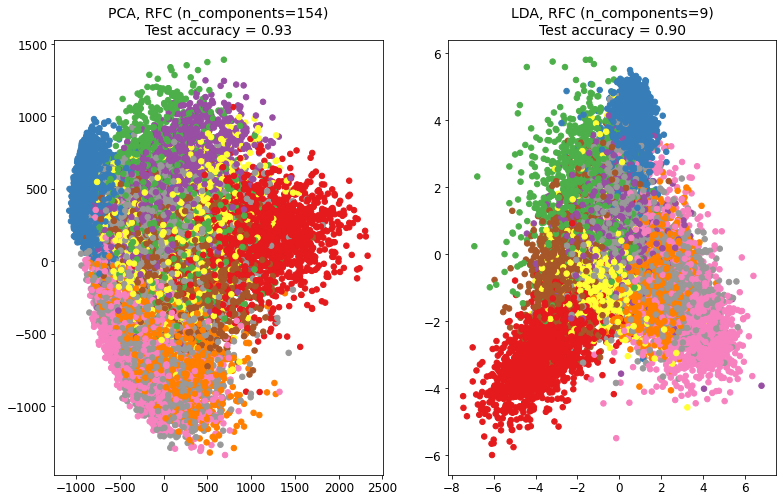

In [51]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

""" Note: cannot use more than 20k observations because of t-SNE which is too slow!"""

n_components = 30
pca_components = 154
random_state = 0
n_classes = len(np.unique(y_train))
plt.figure(figsize=(20,8))

# Reduce dimension with PCA
pca = PCA(n_components=pca_components, random_state=random_state)

# Reduce dimension with LDA
lda = LDA(n_components=n_classes-1)

# Reduce dimension with t-SNE OUPS! CANNOT BE USED because no transform() method...
# tsne = TSNE(n_components=2, perplexity=40, n_iter=300)

# Classifier to evaluate the methods
rfc = RandomForestClassifier(class_weight='balanced',
                            random_state=1,
                            n_jobs=-1)

# Make a list of the methods to be compared
dim_reduction_methods = [("PCA", pca), ("LDA", lda)]

# Plot results
for i, (name, model) in enumerate(dim_reduction_methods):
    plt.subplot(1, 3, i + 1)

    # Fit the method's model
    model.fit(X_train[0:20000], y_train[0:20000])

    # Fit a classifier on the training set
    rfc.fit(model.transform(X_train[0:20000]), y_train[0:20000])

    # Compute the model accuracy on the test set
    acc_rfc = rfc.score(model.transform(X_test[0:20000]), y_test[0:20000])

    # Embed the training set in 2D using the fitted model
    X_embedded = model.transform(X_train[0:20000])

    # Plot the projected points and show the evaluation (accuracy) score
    plt.scatter(X_embedded[:, 0],
                X_embedded[:, 1],
                c=y_train[0:20000], s=30, cmap='Set1')
    plt.title("{}, RFC (n_components={})\nTest accuracy = {:.2f}".format(name, model.n_components, acc_rfc), fontsize=14)

plt.show()

In [52]:
# Since t-SNE doesn't have a transform() method, we need to transform it mannually to compare with the others:

""" Note: cannot use more than 20k observations because of t-SNE is too slow"""

# TSNE
X_reduced_tsne_pca = TSNE(n_components=2, perplexity=40, n_iter=300).fit_transform(X_reduced_pca[0:20000])

# LDA
X_reduced_lda = LDA(n_components=9).fit_transform(X_train[0:20000], y_train[0:20000])

# PCA
X_reduced_pca = PCA(n_components=154, random_state=1).fit_transform(X_train[0:20000])

#---------------------------------------------------------------------------

titles = ['t-SNE', 'LDA', 'PCA']

plt.figure(figsize=(25,8))

for subplot, title, X_reduced in zip((131, 132, 133), titles,(X_reduced_tsne_pca, X_reduced_lda, X_reduced_pca)):
    plt.subplot(subplot)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df.label[0:20000], cmap=plt.cm.tab10)
    
    # Settings
    plt.title(title, fontsize=24)
    plt.xlabel("$z_1$", fontsize=18)
    plt.grid(True)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    
plt.show()


**Note:**<br>
As observed from the scatter plots, we can make out a few discernible clusters evinced from the collective blotches of colors with t-SNE and LDA. From the t-SNE scatter plot the first thing that strikes is that clusters are very well defined and segregated. Based on this comparison graph, t-SNE seems better to differentiate between clusters but we already decided that this is not a good option for dimensionality reduction. We can see that the data points are more clearly clustered when using LDA as compared to implementing PCA with class labels. This is an inherent advantage in having class labels to supervise the method (LDA) with versus unsupervised (PCA). Therefore, LDA seems to be the best dimentionality reduction method for this dataset. 

Next, let's explore performance metrics for LDA to compare it to Baseline model later on.



# Reduction Model - LDA

We need to find out what is the optimal number of components knowing that the maximum is the number of classes-1

In [53]:
from sklearn.model_selection import cross_val_score

""" This cell is inactive because I don't run the code everytime."""
'''
# Define a function to create a list of components (models) to evaluate
def get_models():
	models = dict()
 
	for i in range(1,10):
		models[str(i)] = Pipeline([
                            ('lda', LinearDiscriminantAnalysis(n_components=i)),
                            ('m', RandomForestClassifier())
                              ])
	return models
 
# Define a function to evaluate models using cross-validation
def evaluate_model(model, X, y):
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=3, n_jobs=-1)
	return scores
 
# Define X and y
X, y = X_train, y_train

# Get the list of models to evaluate
models = get_models()

# Perform the evaluations and store results
results, names = list(), list()

for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('component=%s >> %.3f' % (name, np.mean(scores)))

# Plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.xlabel('Number of components')
plt.ylabel('Accuracy score')
plt.show()
'''

"\n# Define a function to create a list of components (models) to evaluate\ndef get_models():\n\tmodels = dict()\n \n\tfor i in range(1,10):\n\t\tmodels[str(i)] = Pipeline([\n                            ('lda', LinearDiscriminantAnalysis(n_components=i)),\n                            ('m', RandomForestClassifier())\n                              ])\n\treturn models\n \n# Define a function to evaluate models using cross-validation\ndef evaluate_model(model, X, y):\n\tscores = cross_val_score(model, X, y, scoring='accuracy', cv=3, n_jobs=-1)\n\treturn scores\n \n# Define X and y\nX, y = X_train, y_train\n\n# Get the list of models to evaluate\nmodels = get_models()\n\n# Perform the evaluations and store results\nresults, names = list(), list()\n\nfor name, model in models.items():\n\tscores = evaluate_model(model, X, y)\n\tresults.append(scores)\n\tnames.append(name)\n\tprint('component=%s >> %.3f' % (name, np.mean(scores)))\n\n# Plot model performance for comparison\nplt.boxplot(results

Note:<br>
The optimal n_components for LDA = 9

## Visualization - LDA

In [54]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Fit the transformer with training data on the features only (LDA requires also labels for this task)
lda = LDA(n_components=9).fit(X_train, y_train)

# Transform X_train into a reduced array (60000,9)
X_reduced_lda = lda.transform(X_train)

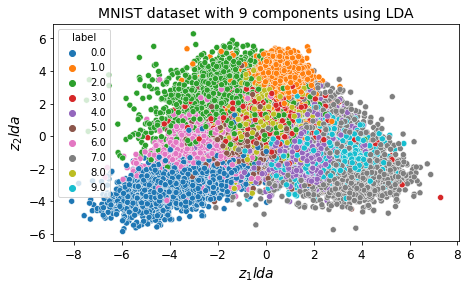

In [55]:
# Create a smaller DF so that results can be added
df_train = df[0:60000]

# Add results to the DF
df_train['$z_1lda$'] = X_reduced_lda[:,0]
df_train['$z_2lda$'] = X_reduced_lda[:,1]

# Pre-settings
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 2, 1)

# Plot first 2 components from LDA (n_components=9)
sns.scatterplot(
    x='$z_1lda$',
    y='$z_2lda$',
    data=df_train,
    hue='label',
    palette=sns.color_palette('tab10', 10),
    legend="full",
    # alpha=0.3,
    ax=ax1)

# Settings
plt.title('MNIST dataset with 9 components using LDA', fontsize=14)
plt.show()

Since it has 9 dimensions, let's have a look also at the reduced dataset in 3D

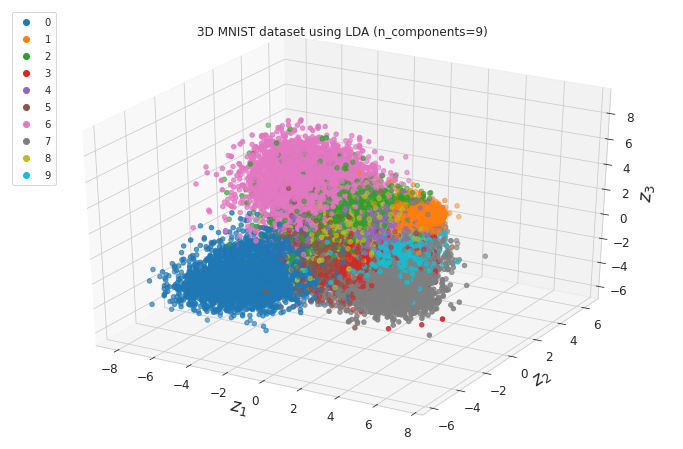

In [56]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# Pre-settings
sns.set_style("whitegrid", {'axes.grid' : False})
cmap = ListedColormap(sns.color_palette('tab10').as_hex())
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection = '3d')
c = df.label[0:60000]

# Plot
x = X_reduced_lda[:,0]
y = X_reduced_lda[:,1]
z = X_reduced_lda[:,2]

sc = ax.scatter(x, y, z, c=c, marker='o',cmap=cmap)

# Settings
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18)
ax.set_zlabel("$z_3$", fontsize=18)
plt.title('3D MNIST dataset using LDA (n_components=9)')
plt.legend(*sc.legend_elements(), loc=2)
plt.show()

Same as the graph before, we can see different clusters of data. Let's look at the performance measures next.

## Pipeline - LDA

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from time import time
t0 = time()

# Full pipeline (transformers + estimator)
full_pipe_lda = Pipeline([
                ('reducer', LDA(n_components=9)),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('classifier', RandomForestClassifier(class_weight='balanced', random_state=1, n_jobs=-1,))
                ])

# Fit (and transform) the pipeline to training data to create a new model as an object
rfc_lda = full_pipe_lda.fit(X_train, y_train)

#--------------------------------------------------------------------
# Processing time
pipe_lda = time() - t0
print('Pipeline Time : %d seconds' % pipe_lda)

Pipeline Time : 42 seconds


## Performance - LDA

In [58]:
from time import time
t0 = time()

# Define model
model = rfc_lda

# Compute predictions (yhat) using test set (10000,)
yhat_lda = model.predict(X_test)

# List of probabilities that the classifier assigned using test set (10000,)
yproba_lda = model.predict_proba(X_test)

#------------------------------------------------------------------------------------------
# Processing time
prediction_lda = time() - t0
print('Classifier Train Time : %d seconds' % prediction_lda)

Classifier Train Time : 0 seconds


In [59]:
from sklearn.metrics import classification_report

target_names = ['label 0', 'label 1', 'label 2', 'label 3','label 4','label 5','label 6','label 7','label 8','label 9']

# Create the classification report
report_lda = classification_report(y_test, yhat_lda, target_names=target_names, digits=3, output_dict=True)
f1_lda = report_lda['macro avg']['f1-score']

# Print the Classification Report
print('Classification Report\n >> Training Set <<\n' + classification_report(y_test, yhat_lda, target_names=target_names, digits=3))

#--------------------------------------------------------------------------------------------------------------------------
# Print the accuracy score (%)
accuracy_lda = report_lda['accuracy']
print('Accuracy >>> {}'.format(round(accuracy_lda*100, 1)), '%\n') 

#------------------------------------------------------------------------------------------------------------------------------------------------
from sklearn.metrics import roc_auc_score

# ROC AUC for multiclass using macro average
macro_roc_auc_lda = roc_auc_score(y_test, yproba_lda, multi_class='ovr', average='macro')

# Print ROC AUC scores
print("One-vs-Rest ROC AUC scores: \n{:.4f} (macro)".format(macro_roc_auc_lda))

Classification Report
 >> Training Set <<
              precision    recall  f1-score   support

     label 0      0.961     0.961     0.961       959
     label 1      0.954     0.973     0.964      1155
     label 2      0.904     0.909     0.906      1007
     label 3      0.893     0.886     0.890      1039
     label 4      0.898     0.919     0.908       925
     label 5      0.861     0.866     0.864       921
     label 6      0.945     0.950     0.947       972
     label 7      0.925     0.935     0.930      1048
     label 8      0.879     0.863     0.871       953
     label 9      0.911     0.870     0.890      1021

    accuracy                          0.914     10000
   macro avg      0.913     0.913     0.913     10000
weighted avg      0.914     0.914     0.914     10000

Accuracy >>> 91.4 %

One-vs-Rest ROC AUC scores: 
0.9936 (macro)


# DR methods performance summary

We compared different dimensionality reduction methods visually and we determined that t-SNE and LDA are the top 2. We also mentioned that unfortunately t-SNE is slow but let's compare all the performance metrics side-by-side in order to find out which dimensionality reduction method, if any, is appropriate to reduce the number of features in this dataset. 

In [60]:
# Print time to apply the reducer and to train the Classifier
print('Time to reduce dataset and train the Classifier:\n')
print(f'Baseline ({X_train.shape[0]} observations) >> %d seconds' % pipe_pre)
print(f'PCA ({X_train.shape[0]} observations) >> %d seconds' % pipe_pca)
print(f'TSNE ({X_reduced_pca.shape[0]} observations) >> %d seconds' % pipe_tsne_pca)
print(f'LDA ({X_train.shape[0]} observations) >> %d seconds' % pipe_lda)

# Print time to compute predictions
print('\nTime to compute predictions:\n')
print('Baseline >> %d seconds' % prediction_pre)
print('PCA >> %d seconds' % prediction_pca)
print('TSNE >> %d seconds' % prediction_tsne_pca)
print('LDA >> %d seconds' % prediction_lda)

# Print total processing time 
print('\nTotal Computational Cost:\n')
print('Baseline >> %d seconds' % (pipe_pre + prediction_pre))
print('PCA >> %d seconds' % (pipe_pca + prediction_pca))
print('TSNE >> %d seconds' % (pipe_tsne_pca + prediction_tsne_pca))
print('LDA >> %d seconds' % (pipe_lda + prediction_lda))

# Accuracy
print('\nModel Accuracy:\n')
print('Baseline (n=784) >>', round((accuracy_pre*100),1), '%')
print('PCA (n=154) >>', round((accuracy_pca*100),1), '%')
print('TSNE (n=2) >>', round((accuracy_tsne*100),1), '%')
print('LDA (n=9) >>', round((accuracy_lda*100),1), '%')

# F1 Score
print('\nModel F1 Score:\n')
print('Baseline (n=784) >> %.2f'%f1_pre)
print('PCA (n=154) >> %.2f' %f1_pca)
print('TSNE (n=2) >> %.2f' %f1_tsne)
print('LDA (n=9) >> %.2f' %f1_lda)

# ROC AUC
print('\nModel ROC AUC (macro average):\n')
print('Baseline (d=784) >> %.3f' %macro_roc_auc_pre)
print('PCA (d=154) >> %.3f' %macro_roc_auc_pca)
print('TSNE (d=2) >> %.3f' %macro_roc_auc_tsne)
print('LDA (d=9) >> %.3f' %macro_roc_auc_lda)

Time to reduce dataset and train the Classifier:

Baseline (60000 observations) >> 42 seconds
PCA (60000 observations) >> 101 seconds
TSNE (20000 observations) >> 255 seconds
LDA (60000 observations) >> 42 seconds

Time to compute predictions:

Baseline >> 1 seconds
PCA >> 1 seconds
TSNE >> 12 seconds
LDA >> 0 seconds

Total Computational Cost:

Baseline >> 43 seconds
PCA >> 102 seconds
TSNE >> 267 seconds
LDA >> 43 seconds

Model Accuracy:

Baseline (n=784) >> 97.0 %
PCA (n=154) >> 94.8 %
TSNE (n=2) >> 89.2 %
LDA (n=9) >> 91.4 %

Model F1 Score:

Baseline (n=784) >> 0.97
PCA (n=154) >> 0.95
TSNE (n=2) >> 0.89
LDA (n=9) >> 0.91

Model ROC AUC (macro average):

Baseline (d=784) >> 0.999
PCA (d=154) >> 0.997
TSNE (d=2) >> 0.982
LDA (d=9) >> 0.994


In [61]:
# Best performances
print(f"""
Reducing and training time: 
the fastest is LDA with {round(pipe_lda)} seconds. The second fastest is actually Baseline with {round(pipe_pre-pipe_lda)} seconds slower whereas all other models take longer.
The slowest of all models is t-SNE (6x slower than Baseline) with only 1/3 of the dataset! NCA could not even be tried on 1/3 dataset because Google Colab would run out
of RAM every time and would crash the kernel. Not very useful!!

Prediction time: 
all models are fast except for t-SNE because it needs to use cross-validation with X_train to compute y_pred.

Accuracy: 
it is clear that all performance measures decreases as the number of components decreases. Therefore, as expected, 
the best accuracy ({round((accuracy_pre*100),1)}%) is with the Baseline model because there is no loss of information from dimensionality reduction

F1 score: 
the best F1 score ({round((f1_pre),2)}) is with the Baseline model because there is no loss of information from dimensionality reduction

ROC AUC: 
the best ROC AUC ({round((macro_roc_auc_pre),3)}) is with the Baseline model because there is no loss of information from dimensionality reduction

No surprise that the Baseline model with 784 dimensions has the best performance measures and that PCA is second with its 154 dimensions and 95% retained variance. 
However, overall PCA is {round((pipe_pre-pipe_pca) + (pipe_pca+prediction_pre))} seconds slower than Baseline meaning that PCA fails in processing time and in performance as compared to Baseline. 
The next dimensionality reduction method in line is LDA with 9 components. Overall processing time is on par with Baseline ({round(((pipe_pre+prediction_pre) - (pipe_lda+prediction_lda)))} seconds difference between the two)
but LDA doesn't perform as good as Baseline. 
As for TSNE, I consider that it's the best method to represent the dataset visually but not as a feature reduction technique. 
All the other methods considered in this notebook greatly fail at dimensionality reduction with this dataset and are not good options.

Final thoughts:
I guess among the 10 dimensionality reduction methods explored in this notebook, none seem to outperform the Baseline model in total time and in model performance.
""")


Reducing and training time: 
the fastest is LDA with 43 seconds. The second fastest is actually Baseline with 0 seconds slower whereas all other models take longer.
The slowest of all models is t-SNE (6x slower than Baseline) with only 1/3 of the dataset! NCA could not even be tried on 1/3 dataset because Google Colab would run out
of RAM every time and would crash the kernel. Not very useful!!

Prediction time: 
all models are fast except for t-SNE because it needs to use cross-validation with X_train to compute y_pred.

Accuracy: 
it is clear that all performance measures decreases as the number of components decreases. Therefore, as expected, 
the best accuracy (97.0%) is with the Baseline model because there is no loss of information from dimensionality reduction

F1 score: 
the best F1 score (0.97) is with the Baseline model because there is no loss of information from dimensionality reduction

ROC AUC: 
the best ROC AUC (0.999) is with the Baseline model because there is no loss

# Final Model

Baseline model it is !
Let's do a model tune-up to see if we can improve the Baseline model

## Pipeline - Final

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from time import time
t0 = time()

# Build pipeline
pipe_final = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('classifier', RandomForestClassifier(class_weight='balanced', random_state=1, n_jobs=-1))
                ])

# Fit (and transform) the pipeline to training data to create a model as an object
rfc_final = pipe_final.fit(X_train, y_train)

print('\nTime elapsed: %d seconds' % (time() - t0))


Time elapsed: 44 seconds


## Hyperparameters Search

Let's run a GirdSearch to find the best hyperparameters of the model.

In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, MaxAbsScaler
from time import time
t0 = time()

""" This cell is inactive because I don't run the code everytime."""

'''
classifier = RandomForestClassifier(class_weight='balanced', random_state=1, n_jobs=-1)

# Define hyperparameters/methods to test
param_grid = {
    'classifier__max_depth': [50, 100],
    # 'classifier__min_samples_leaf': [2, 5],
    # 'classifier__min_samples_split': [2, 5],
    # 'classifier__n_estimators': [100, 200, 300],
    # 'classifier__n_features': [20,30,40,50,100,150]
    # 'reducer__n_components': [i for i in range(2,10)], # 10 labels/classes
    # 'scaler': [StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler()]
            }

# Pass the model/pipeline, parameter grid, and cross-validation parameters
grid_search = GridSearchCV(pipe_final, param_grid, cv=2, verbose=3, n_jobs=-1)
# grid_search = GridSearchCV(classifer, param_grid, cv=2, verbose=3, n_jobs=-1)

# Train the model using the training set
grid_search.fit(X_train, y_train) # when pipeline only???


# Access the best set of parameters
best_params = grid_search.best_params_
print('\nBest estimators found by grid search: ', best_params)
print(f"\nCross-validation scores obtained by those parameters >>> {grid_search.best_score_:.3f}")


#-----------------------------------------------------------------------------------------------------
# Processing time
delta_gs_pre = time() - t0
print('\nGrid Search Time : %d seconds' % delta_gs_pre)
'''

'\nclassifier = RandomForestClassifier(class_weight=\'balanced\', random_state=1, n_jobs=-1)\n\n# Define hyperparameters/methods to test\nparam_grid = {\n    \'classifier__max_depth\': [50, 100],\n    # \'classifier__min_samples_leaf\': [2, 5],\n    # \'classifier__min_samples_split\': [2, 5],\n    # \'classifier__n_estimators\': [100, 200, 300],\n    # \'classifier__n_features\': [20,30,40,50,100,150]\n    # \'reducer__n_components\': [i for i in range(2,10)], # 10 labels/classes\n    # \'scaler\': [StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler()]\n            }\n\n# Pass the model/pipeline, parameter grid, and cross-validation parameters\ngrid_search = GridSearchCV(pipe_final, param_grid, cv=2, verbose=3, n_jobs=-1)\n# grid_search = GridSearchCV(classifer, param_grid, cv=2, verbose=3, n_jobs=-1)\n\n# Train the model using the training set\ngrid_search.fit(X_train, y_train) # when pipeline only???\n\n\n# Access the best set of parameters\nbest_params = grid_search.best_

**Note:**<br>
From hyperparameters search the optimal results are:
   - classifier_max_depth: 50
   - classifier_min_samples_leaf: 2
   - classifier_min_samples_split: 2
   - classifier_n_estimators: 200

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

pipe_final = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('classifier', RandomForestClassifier(
                            n_estimators=200,
                            class_weight='balanced',
                            max_depth=50,
                            min_samples_leaf=2,
                            min_samples_split=2,
                            random_state=1,
                            n_jobs=-1))
                ])

# Fit (and transform) the pipeline to create the final model as an object
rfc_final = pipe_final.fit(X_train, y_train)


## Evaluate the Final Model (generalization)

In [65]:
from sklearn.model_selection import cross_val_predict
# Determine model
model = rfc_final

# Create predictions (y_hat) using the training and test set from the final pipeline
yhat_train = cross_val_predict(model, X_train, y_train, cv=3, method='predict') 
yhat_test = model.predict(X_test)

# List of probabilities that the classifier assigned to using training and test sets from the final pipeline
yproba_train = cross_val_predict(model, X_train, y_train, cv=3, method='predict_proba') 
yproba_test = model.predict_proba(X_test)

Performance Measures comparison between the training and test sets for the final model

In [66]:
from sklearn.metrics import classification_report

# Create the classification reports
report_train = classification_report(y_train, yhat_train, digits=3, output_dict=True)
report_test = classification_report(y_test, yhat_test, digits=3, output_dict=True)

#------------------------------------------------------------------------------------------------------------
# Extract performance measures
accuracy_train = report_train['accuracy']
accuracy_test = report_test['accuracy']
f1_train = report_train['macro avg']['f1-score']
f1_test = report_test['macro avg']['f1-score']

# Computer ROC AUC
from sklearn.metrics import roc_auc_score

auc_train = roc_auc_score(y_train, yproba_train, multi_class='ovr', average='macro')
auc_test = roc_auc_score(y_test, yproba_test, multi_class='ovr', average='macro')

In [67]:
# Print performance results
print('\n GENERALIZATION RESULTS ARE IN !!\n')
print('Accuracy >> {:.1f} % <<'.format(accuracy_test*100))
print("   Baseline model (using test set): {:.1f} %".format(accuracy_pre*100))
print("   After tuning (using test set): {:.1f} %".format(accuracy_test*100))
print("   After tuning (using train set): {:.1f} %".format(accuracy_train*100))

print('\nF1 score >> {:.3f} <<' .format(f1_test))
print("   Baseline model (using test set): {:.3f}".format(f1_pre))
print("   After tuning (using test set): {:.3f}".format(f1_test))
print("   After tuning (using train set): {:.3f}".format(f1_train))

print('\nROC AUC scores >> {:.3f} <<'.format(auc_test))
print("   Baseline model (using test set): {:.3f}".format(macro_roc_auc_pre))
print("   After tuning (using test set): {:.3f}".format(auc_test))
print("   After tuning (using train set): {:.3f}".format(auc_train))


 GENERALIZATION RESULTS ARE IN !!

Accuracy >> 96.8 % <<
   Baseline model (using test set): 97.0 %
   After tuning (using test set): 96.8 %
   After tuning (using train set): 96.5 %

F1 score >> 0.968 <<
   Baseline model (using test set): 0.970
   After tuning (using test set): 0.968
   After tuning (using train set): 0.965

ROC AUC scores >> 0.999 <<
   Baseline model (using test set): 0.999
   After tuning (using test set): 0.999
   After tuning (using train set): 0.999


**Note:**<br>
For whatever reason, the performance metrics using the hyperparameters from GridSearch did not improve from baseline model, but I must say how can we improve a close to perfection model :p<br>
However we can determine that the final model generalizes very well to unseen data (test set).

# Conclusion

A full week of work to finally realize that the plain vanilla RFC model has the best performance of all !!! <br>
Dimensionality reduction is not so glorious and is a bit depressing...